## LSTM AUTOENCODER

In [1]:
from data_processing import process
filename = 'gear_dataset.csv'
rows = 1000
data = process(filename,rows)
n_rows = data.shape[0] 
n_features = data.shape[1]

In [2]:
from matplotlib import pyplot
import keras
import tensorflow as tf
from keras.models import Model
from keras.models import Sequential
from keras.layers import Input
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import TimeDistributed
from keras.layers import RepeatVector
from keras.layers import GRU
from keras.utils import plot_model
from keras.callbacks import EarlyStopping
import numpy as np
from numpy import array


In [3]:
from overlapping_window import overlap_window

time_steps = 40
a = np.r_[0:n_rows]

X_train_samples = overlap_window(time_steps,20,a)
X_train = data[X_train_samples,:]
X_train = np.squeeze(X_train)
# print(X_train.shape)

X_reversed = np.flip(X_train,1)

In [12]:
print(X_reversed[0,:,0])
print(X_train[0,:,0])

[0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 1 1 0 0 0 1 0 0 0 1 0 1 0 0
 0 0 0]
[0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 1 1 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0
 0 0 0]


In [8]:
 print(X_train.shape)

(48, 40, 64)


In [4]:
n_samples = X_train.shape[0]
time_steps = X_train.shape[1]
n_features = X_train.shape[2]


lstm_initializer = tf.keras.initializers.RandomUniform(minval=-0.5, maxval=0.5)

encoderLSTM = LSTM(128,return_sequences=True,kernel_initializer =lstm_initializer, recurrent_initializer=lstm_initializer)

# define Encoder
EncoderInputs = Input(shape=(time_steps,n_features))
dense1 =Dense(256, activation='tanh')(EncoderInputs)
dropout = Dropout(0.2)(dense1)
lstm1 = encoderLSTM(dropout)
lstm2, state_h, state_c = LSTM(128,return_sequences=True,return_state=True,kernel_initializer =lstm_initializer, recurrent_initializer=lstm_initializer)(lstm1)
encoder_states = [state_h, state_c]

# define Decoder
lstm3 =  LSTM(128,return_sequences=True,kernel_initializer =lstm_initializer, recurrent_initializer=lstm_initializer)(lstm2,initial_state=encoder_states)
lstm4 = LSTM(128,return_sequences=True,kernel_initializer =lstm_initializer, recurrent_initializer=lstm_initializer)(lstm3)
dense2 = Dense(256, activation='sigmoid')(lstm4)
output = Dense(n_features,activation= 'sigmoid')(dense2)

EncoderDecoder = Model(inputs=EncoderInputs, outputs=output,name="EncoderDecoder")
EncoderDecoder.compile(optimizer='adam', loss='binary_crossentropy')
EncoderDecoder.summary()

Model: "EncoderDecoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40, 64)]     0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 40, 256)      16640       input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 40, 256)      0           dense[0][0]                      
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 40, 128)      197120      dropout[0][0]                    
_____________________________________________________________________________________

In [4]:
def model_builder(hp):
   # do the lstm layers need to have the same number of units? will do that
   # do the two dense layers need to have the same number of units?
    n_samples = X_train.shape[0]
    time_steps = X_train.shape[1]
    n_features = X_train.shape[2]


    uniformInitializerMin = hp.Float('uniformMin', min_value=-1, max_value=0,step=0.01)
    uniformInitializerMax = hp.Float('uniformMax', min_value=0, max_value=1,step=0.01)
    lstm_initializer = tf.keras.initializers.RandomUniform(minval=uniformInitializerMin, maxval=uniformInitializerMax) 
    
    lstm_units = hp.Int('lstmUnits', min_value=1, max_value=500, step=10)

    # define Encoder
    EncoderInputs = Input(shape=(time_steps,n_features))
    
    dense_units = hp.Int('denseUnits', min_value=10, max_value=5000, step=50)
    dense1 =Dense(units=dense_units, activation='tanh')(EncoderInputs)
    
    dropoutP = hp.Float('dropout',min_value=0.0, max_value=0.95, step=0.05)
    dropout = Dropout(dropoutP)(dense1) 
  
    lstm1,state_h,state_c = LSTM(units=lstm_units,kernel_initializer =lstm_initializer, recurrent_initializer=lstm_initializer, return_state = True)(dropout)
    lstm2, state_h,state_c = LSTM(units=lstm_units,kernel_initializer =lstm_initializer, recurrent_initializer=lstm_initializer, return_state = True)(dropout,initial_state=[state_h,state_c])

    #decoder
    lstm3, state_h, state_c = LSTM(units=lstm_units,kernel_initializer =lstm_initializer, recurrent_initializer=lstm_initializer, return_state = True)(dropout,initial_state=[state_h,state_c])
    lstm4 = LSTM(units=lstm_units,kernel_initializer =lstm_initializer, recurrent_initializer=lstm_initializer, return_sequences = True)(dropout,initial_state=[state_h,state_c])

    
    output = Dense(n_features,activation= 'sigmoid')(lstm4)
    
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    EncoderDecoder = Model(inputs=EncoderInputs, outputs=output,name="EncoderDecoder")
    EncoderDecoder.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate), loss='binary_crossentropy')#, metrics=[tf.keras.metrics.BinaryCrossentropy()])

    return EncoderDecoder

In [5]:
import kerastuner as kt
tuner = kt.Hyperband(model_builder,
                     overwrite=True,
                     objective='val_loss',
                     max_epochs=100,
                     factor=3,
                     directory='C:\ tune',
                     #directory='tuning',
                     project_name='LSTM' 
                     )

es= EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=10)
tuner.search(X_train, X_train, epochs=1000, validation_split=0.2, callbacks=[es])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=10)[0]

Trial 18 Complete [00h 01m 17s]
val_loss: 0.40677374601364136

Best val_loss So Far: nan
Total elapsed time: 00h 14m 14s

Search: Running Trial #19

Hyperparameter    |Value             |Best Value So Far 
uniformMin        |-0.74             |-0.9              
uniformMax        |0.16              |0.91              
lstmUnits         |191               |401               
denseUnits        |4110              |4960              
dropout           |0.65              |0.45              
learning_rate     |0.01              |0.001             
tuner/epochs      |4                 |2                 
tuner/initial_e...|0                 |0                 
tuner/bracket     |1                 |2                 
tuner/round       |0                 |0                 

Epoch 1/4
2/2 [==============================] - 7s 4s/step - loss: 0.7034 - val_loss: 0.6615
Epoch 2/4
2/2 [==============================] - 6s 3s/step - loss: 0.6622 - val_loss: 0.6453
Epoch 3/4


KeyboardInterrupt: 

Epoch 1/300
2/2 - 4s - loss: 0.7059 - val_loss: 0.6740
Epoch 2/300
2/2 - 0s - loss: 0.6788 - val_loss: 0.6525
Epoch 3/300
2/2 - 0s - loss: 0.6558 - val_loss: 0.6341
Epoch 4/300
2/2 - 0s - loss: 0.6374 - val_loss: 0.6126
Epoch 5/300
2/2 - 0s - loss: 0.6185 - val_loss: 0.5961
Epoch 6/300
2/2 - 0s - loss: 0.5998 - val_loss: 0.5808
Epoch 7/300
2/2 - 0s - loss: 0.5820 - val_loss: 0.5659
Epoch 8/300
2/2 - 0s - loss: 0.5677 - val_loss: 0.5517
Epoch 9/300
2/2 - 0s - loss: 0.5526 - val_loss: 0.5383
Epoch 10/300
2/2 - 0s - loss: 0.5378 - val_loss: 0.5277
Epoch 11/300
2/2 - 0s - loss: 0.5265 - val_loss: 0.5185
Epoch 12/300
2/2 - 0s - loss: 0.5161 - val_loss: 0.5108
Epoch 13/300
2/2 - 0s - loss: 0.5083 - val_loss: 0.5035
Epoch 14/300
2/2 - 0s - loss: 0.5010 - val_loss: 0.4973
Epoch 15/300
2/2 - 0s - loss: 0.4950 - val_loss: 0.4915
Epoch 16/300
2/2 - 0s - loss: 0.4892 - val_loss: 0.4855
Epoch 17/300
2/2 - 0s - loss: 0.4832 - val_loss: 0.4795
Epoch 18/300
2/2 - 0s - loss: 0.4777 - val_loss: 0.4734
E

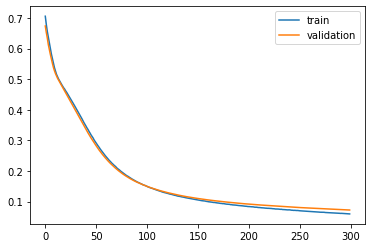

training time = 273.8885097503662 seconds


In [5]:
n_samples = X_train.shape[0]
time_steps = X_train.shape[1]
n_features = X_train.shape[2]
import time
train_size = int(np.floor(0.7*n_samples))

model = EncoderDecoder
es= EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=10)

s=time.time()

history = model.fit(X_train[0:train_size,:,:], X_train[0:train_size,:,:], validation_data=(X_train[train_size:,:,:], X_train[train_size:,:,:]), epochs=300, verbose=2, shuffle=False, callbacks = [es])

e=time.time()

# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='validation')

pyplot.legend()
pyplot.show()
print(f'training time = {e-s} seconds')

Model: "EncoderDecoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40, 64)]     0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 40, 256)      16640       input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 40, 256)      0           dense[0][0]                      
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 128), (None, 197120      dropout[0][0]                    
_____________________________________________________________________________________

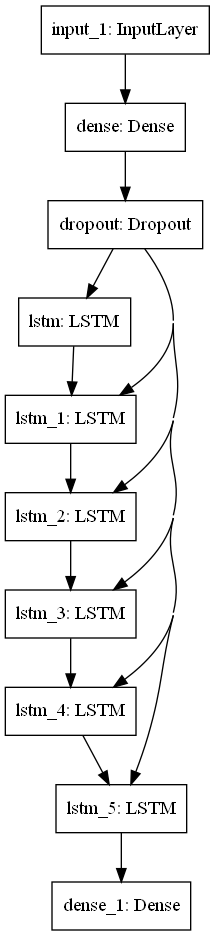

In [4]:
n_samples = X_train.shape[0]
time_steps = X_train.shape[1]
n_features = X_train.shape[2]


lstm_initializer = tf.keras.initializers.RandomUniform(minval=-0.5, maxval=0.5)


# define Encoder
EncoderInputs = Input(shape=(time_steps,n_features))
dense1 =Dense(256, activation='tanh')(EncoderInputs)
dropout = Dropout(0.2)(dense1)

encoderLSTM1 = LSTM(128,kernel_initializer =lstm_initializer, recurrent_initializer=lstm_initializer, return_state = True)
lstm1, state_h, state_c = encoderLSTM1(dropout)

encoderLSTM2 = LSTM(128,kernel_initializer =lstm_initializer, recurrent_initializer=lstm_initializer, return_state = True)
lstm2, state_h, state_c =encoderLSTM2(dropout,initial_state=[state_h,state_c])

encoderLSTM3 = LSTM(128,kernel_initializer =lstm_initializer, recurrent_initializer=lstm_initializer, return_state = True)
lstm5, state_h, state_c =encoderLSTM3(dropout,initial_state=[state_h,state_c])

# define Decoder
decoderLSTM1 = LSTM(128,return_state=True,kernel_initializer =lstm_initializer, recurrent_initializer=lstm_initializer)
lstm3, state_h, state_c =  decoderLSTM1(dropout,initial_state=[state_h, state_c])

decoderLSTM2 =  LSTM(128,return_sequences=True,return_state=True,kernel_initializer =lstm_initializer, recurrent_initializer=lstm_initializer)
lstm4, state_h, state_c = decoderLSTM2(dropout,initial_state=[state_h,state_c])

decoderLSTM3 =  LSTM(128,return_sequences=True,kernel_initializer =lstm_initializer, recurrent_initializer=lstm_initializer)
lstm6 = decoderLSTM3(dropout,initial_state=[state_h,state_c])

#dense2 = Dense(256, activation='sigmoid')(lstm4)
output = Dense(n_features,activation= 'sigmoid')(lstm6)

EncoderDecoder = Model(inputs=EncoderInputs, outputs=output,name="EncoderDecoder")
EncoderDecoder.compile(optimizer='adam', loss='binary_crossentropy')
EncoderDecoder.summary()
plot_model(EncoderDecoder, to_file='EncoderDecoder.png')

In [ ]:
#300 epochs, loss: 0.0594 - val_loss: 0.0723 all connected to dropout, 256-128*4-256-64
#300 epochs, loss: 0.0544 - val_loss: 0.0674 all connected to dropout, 256-128*4-64
#300 epochs, loss: 0.0919 - val_loss: 0.1074 all connected to dropout, 64-128*4-64
#300 epochs, loss: 0.0904 - val_loss: 0.1021 all connected to dropout, 64-128*2-64
#300 epochs, loss: 0.0598 - val_loss: 0.0726 all connected to dropout, 256-128*6-64